# Load repo

In [1]:
import os
!git clone https://github.com/intory89/StyleVC
os.chdir('StyleVC')
os.getcwd()

Cloning into 'StyleVC'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 120 (delta 3), reused 111 (delta 2), pack-reused 0
Receiving objects: 100% (120/120), 23.07 MiB | 24.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


'/content/StyleVC'

In [19]:
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
!pip install transformers
!pip install jiwer
import jiwer

     |████████████████████████████████| 50 kB 3.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149857 sha256=a78c01cd8194aa64f744d66dc7bf1539fef8b03cb95fcc0c9c1f6458ec18369b
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


# Load checkpoint

In [5]:
!pip install gdown
import shutil
os.makedirs('vocoder/checkpoint/VCTK_16K_V1')
!gdown --id 161vOpseswWQXrMhYs4TF1EBsHaaSmdoC --output g_01700000      
!gdown --id 1lZsurL1LINIKqHOa0MRb7zqnfeH1kGaQ --output config.json 
shutil.move('g_01700000', 'vocoder/checkpoint/VCTK_16K_V1/') 
shutil.move('config.json', 'vocoder/checkpoint/VCTK_16K_V1/')

Downloading...
From: https://drive.google.com/uc?id=161vOpseswWQXrMhYs4TF1EBsHaaSmdoC
To: /content/StyleVC/g_01700000
100% 55.8M/55.8M [00:00<00:00, 66.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lZsurL1LINIKqHOa0MRb7zqnfeH1kGaQ
To: /content/StyleVC/config.json
100% 758/758 [00:00<00:00, 1.54MB/s]


'vocoder/checkpoint/VCTK_16K_V1/config.json'

In [6]:
os.makedirs('outputs/StyleVC_VCTK')
!gdown --id 1k67mGLUCrm3E1kLN-Om3qk-fR9NOJBb1 --output checkpoint_G_100000
shutil.move('checkpoint_G_100000', 'outputs/StyleVC_VCTK/')

Downloading...
From: https://drive.google.com/uc?id=1k67mGLUCrm3E1kLN-Om3qk-fR9NOJBb1
To: /content/StyleVC/checkpoint_G_100000
100% 1.66G/1.66G [00:14<00:00, 114MB/s]


'outputs/StyleVC_VCTK/checkpoint_G_100000'

# Load audio

In [7]:
source_path = os.path.join('data/VCTK/original/wav48/p225/p225_002.wav')
Audio(source_path)

In [8]:
target_path = os.path.join('data/VCTK/original/wav48/p226/p226_005.wav')
Audio(target_path)

# Preprocessing

In [9]:
audio_A, _ = librosa.load(source_path, sr=16000)
audio_B, _ = librosa.load(target_path, sr=16000)

In [10]:
# preprocessing parameters
import model.hparams as hp
MAX_WAV_VALUE       = hp.MAX_WAV_VALUE
sampling_rate       = hp.sampling_rate
n_fft               = hp.n_fft
n_mels              = hp.n_mels
hop_size            = hp.hop_size 
win_size            = hp.win_size 
fmin                = hp.fmin         
fmax                = hp.fmax
eps                 = hp.eps
clip_val            = hp.clip_val

log directory! -----> StyleVC_VCTK
seen speakers! 87 unseen speakers! 20


In [11]:
from preprocessing import call_generate_melspec
mel_A, processed_audio = call_generate_melspec(
    audio_A, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]

mel_B, processed_audio = call_generate_melspec(
    audio_B, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:573: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  normalized, onesided, return_complex)


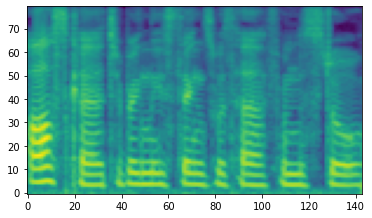

In [12]:
plt.imshow(mel_A.T)
plt.gca().invert_yaxis()

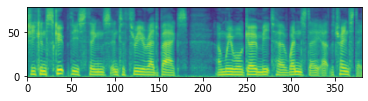

In [13]:
plt.imshow(mel_B.T)
plt.gca().invert_yaxis()

# Load Model

In [21]:
from model.model import Model
import model.hparams as hp
from utils.inference_utils import make_test_pairs, make_experiment_conversion_pair, pad_sequences, load_data
from vocoder.inference_npy import main as run_vocoder
import torch

In [ ]:
# rhythm = read_rhythm(os.path.join('data', hp.dataset, hp.dataset_path, 'rhythm.txt')) 

In [23]:
model = Model(hp).cuda(0)
model.load_state_dict(torch.load('outputs/StyleVC_VCTK/checkpoint_G_100000')['model'])
model.eval()
print("load model!")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored

# Inference

In [ ]:
mel_A = mel_A.unsqueeze(0).cuda(0) # [1, T, 80]
mel_B = mel_B.unsqueeze(0).cuda(0)

mel_len_A = torch.LongTensor([mel_A.size(1)]).cuda(0)
mel_len_B = torch.LongTensor([mel_B.size(1)]).cuda(0)

spk_name_A = 'p225'
spk_name_B = 'p226'

In [ ]:
mel_outputs = model.inference(audio_A, mel_A, mel_len_A, audio_B, mel_B, mel_len_B)
print(mel_outputs.size())

/content/RCVC/model/loss.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  ids = lengths.new_tensor(torch.arange(0, max_len)).to(lengths.get_device())


torch.Size([1, 146, 80])


In [ ]:
# save result
source_mel = mel_A.squeeze(0).float().detach().cpu().numpy().T # [1, T, 80] -> [80, T]
target_mel = mel_B.squeeze(0).float().detach().cpu().numpy().T               
converted_mel = mel_outputs.squeeze(0).float().detach().cpu().numpy().T
path = "p343_to_p311.npy"

# Inference result
os.makedirs('generated/Style_VCTK', exist_ok=True)
np.save(os.path.join('generated/Style_VCTK', path), converted_mel)

# Vocoder

In [ ]:
run_vocoder(hp, path=os.path.join('../generated/Style_VCTK'))

Initializing Inference Process..
[*] Load checkpoint path: vocoder/checkpoint/VCTK_22K_V1/g_00500000
Loading 'vocoder/checkpoint/VCTK_22K_V1/g_00500000'
Complete.
Removing weight norm...
generated/../generated/RCVC_VCTK/p343_to_p311.wav


# Inference result
## Source speech(Slow speaking speaker)

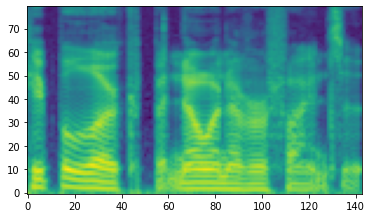

In [ ]:
target_path = os.path.join('data/VCTK/original/wav48/p225/p225_002.wav')
plt.imshow(mel_A.squeeze(0).cpu().T)
plt.gca().invert_yaxis()
Audio(target_path)

## Target speech(Fast speaking speaker)

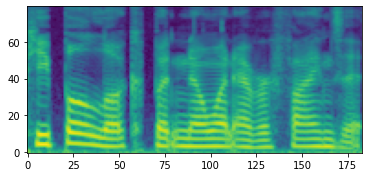

In [ ]:
source_path = os.path.join('data/VCTK/original/wav48/p226/p226_005.wav')
plt.imshow(mel_B.squeeze(0).cpu().T)
plt.gca().invert_yaxis()
Audio(source_path)

## Generated speech

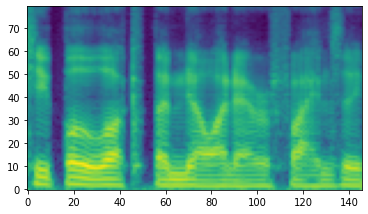

In [ ]:
generated_path = os.path.join('generated/StyleVC_VCTK/p225_to_p226.wav')
generated_audio, _ = librosa.load(generated_path, sr=16000)
mel_A2B, processed_audio = call_generate_melspec(
    generated_audio, sampling_rate, MAX_WAV_VALUE, n_fft, n_mels, 
    hop_size, win_size, fmin, fmax, eps, clip_val) # [T, 80], [trimed wav length]
plt.imshow(mel_A2B.T)
plt.gca().invert_yaxis()
Audio(generated_path)

# Thank you for your attention!